In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import preliz as pz
import pymc as pm

## The R2D2 prior

Suppose we have a normal regression model:

$$
\begin{aligned}
Y_i &\sim \text{Normal}(\mu_i, \sigma^2) \\
\mu_i &= \alpha + \beta_1 X_{1i} + \beta_2 X_{2i} + \dots + \beta_p X_{pi} = \alpha + \boldsymbol{X}\boldsymbol{\beta}
\end{aligned}
$$

where $\boldsymbol{X}$ is the $n \times p$ design matrix (without the intercept) and $\boldsymbol{\beta}$, of length $p$, is the vector of coefficients.

The R2D2 prior model is:

$$
\begin{aligned}
\beta_j &\sim \text{Normal}(0, \phi_j W \sigma^2) \\
\boldsymbol{\phi} &\sim \text{Dirichlet}(\xi_1, \dots, \xi_p) \\
W & = \frac{R^2}{1 - R^2}\\
R^2 &\sim \text{Beta}(a, b) \\
\end{aligned}
$$

Different authors write $R^2$ using slightly different formulas,
but in all cases it represents the ratio of the marginal variance of the linear predictor to the marginal variance of the outcome:

$$
R^2 = \frac{\text{Var}(\boldsymbol{x}^T \boldsymbol{\beta})}{\text{Var}(\boldsymbol{x}^T \boldsymbol{\beta}) + \sigma^2}
= \frac{\sigma^2 W}{\sigma^2 W + \sigma^2} 
= \frac{W}{W + 1}
$$

The R2D2 prior belongs to the family of global-local shrinkage priors. 
Its key feature is that it places a prior directly on the interpretable quantity $R^2$, the coefficient of determination.
Through the transformation $W = R^2/(1-R^2)$, this induces a prior on $W$, which governs the total prior variance of the linear predictor.
The authors of the R2D2 priorshow that the induced prior on $W$ is a Beta Prime distribution with parameters $a$ and $b$.

Let's see if we can recover the true $R^2$ using the R2D2 prior.

### Simulate data

Let's simulate data with 

* $p = 30$, of which 4 are different from zero.
* $n = 1000$
* $\sigma^2 = 3^2$
* $X_i \sim \text{Uniform}(-2, 2)$, but then scaled to have variance 1

In [2]:
rng = np.random.default_rng(1234)

TRUE_ALPHA = 2.5
TRUE_BETAS = pm.draw(
    pm.Normal.dist(
        mu=[0] * 26 + [-2, 2] * 2,
        sigma=[0.05] * 26 + [0.5] * 4
    ),
    random_seed=rng
)
TRUE_SIGMA = 3

n = 1000
p = len(TRUE_BETAS)

X = pm.draw(pm.Uniform.dist(lower=-2, upper=2, shape=p), draws=n)
X_std = X / X.std(0)
y = pm.draw(pm.Normal.dist(mu=TRUE_ALPHA + X_std @ TRUE_BETAS, sigma=TRUE_SIGMA))

#### Check $R^2$

We have that

$$
R^2 = \frac{\text{Var}(\boldsymbol{X}^T \boldsymbol{\beta})}{\text{Var}(\boldsymbol{X}^T \boldsymbol{\beta}) + \sigma^2}
$$

and 
$$
\text{Var}(\boldsymbol{X}^T \boldsymbol{\beta}) = \boldsymbol{\beta}^T \text{Cov}(\boldsymbol{X}) \boldsymbol{\beta} = \boldsymbol{\beta}^T  \Sigma_X  \boldsymbol{\beta}
$$

thus

In [3]:
Sigma = np.eye(p)
mu_var = (TRUE_BETAS.T
           @ Sigma @ TRUE_BETAS)
mu_var / (mu_var + TRUE_SIGMA ** 2)

np.float64(0.5967732927254484)

With scikit learn we can recover this value

In [4]:
# Scikit learn R^2
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model = LinearRegression()
model.fit(X_std, y)
y_pred = model.predict(X_std)
r2_score(y, y_pred)

0.6199857517998408

### Modeling with PyMC: follow the math

In [5]:
def compute_r2(mean, variance):
    mu_var = mean.var("__obs__")
    return mu_var / (mu_var + variance)

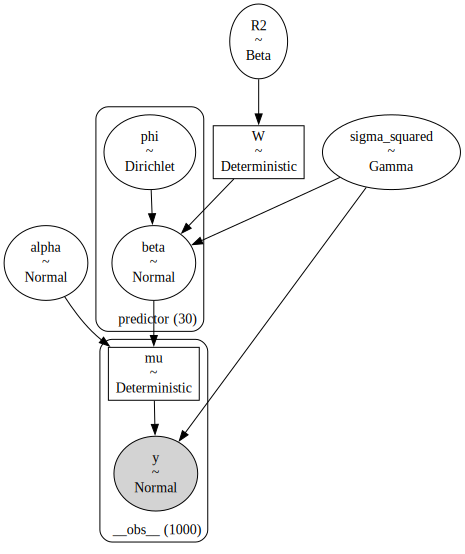

In [6]:
coords = {
    "predictor": np.arange(p),
    "__obs__": np.arange(n)
}

with pm.Model(coords=coords) as model_1:
    sigma_squared = pm.Gamma("sigma_squared", mu=9, sigma=2) # Informative prior
    
    # Non-uniform prior to check something below
    R2 = pm.Beta("R2", alpha=5, beta=3) 
    phi = pm.Dirichlet("phi", a=np.ones(p), dims="predictor")
    W = pm.Deterministic("W", R2 / (1 - R2))

    alpha = pm.Normal("alpha")
    beta = pm.Normal("beta", mu=0, sigma=(phi * W * sigma_squared) ** 0.5, dims="predictor")
    mu = pm.Deterministic("mu", alpha + (X_std @ beta), dims="__obs__")

    pm.Normal("y", mu=mu, sigma=sigma_squared ** 0.5, observed=y, dims="__obs__")

model_1.to_graphviz()

In [7]:
with model_1:
    idata_1 = pm.sample_prior_predictive(draws=10000, random_seed=1234)

/home/tomas/miniconda3/envs/pymc-env/lib/python3.13/site-packages/pytensor/link/c/cmodule.py:3004: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Sampling: [R2, alpha, beta, phi, sigma_squared, y]


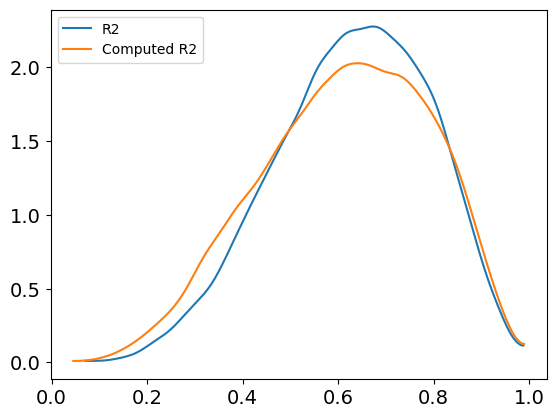

In [8]:
ax = az.plot_dist(idata_1.prior["R2"], label="R2")
az.plot_dist(compute_r2(idata_1.prior["mu"], idata_1.prior["sigma_squared"]), color="C1", label="Computed R2", ax=ax);

In [9]:
print(idata_1.prior["R2"].mean().item()) # Close to 5/8 = 0.625
print(compute_r2(idata_1.prior["mu"], idata_1.prior["sigma_squared"]).mean().item()) # Close to 5/8 = 0.625

0.6283262087752892
0.612894010192802


In [10]:
with model_1:
    idata_1.extend(pm.sample(draws=2000, target_accept=0.99, random_seed=1234))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_squared, R2, phi, alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


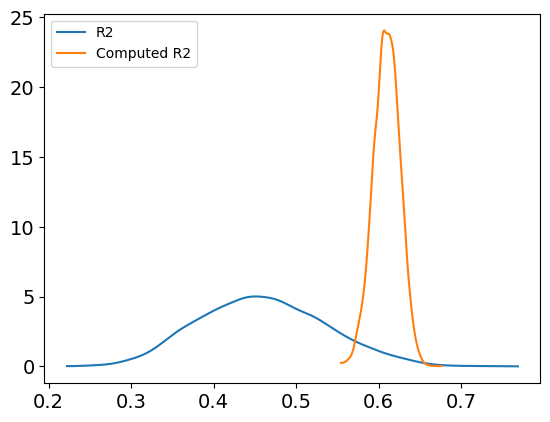

In [11]:
ax = az.plot_dist(idata_1.posterior["R2"], label="R2")
az.plot_dist(compute_r2(idata_1.posterior["mu"], idata_1.posterior["sigma_squared"]), color="C1", label="Computed R2", ax=ax);

Whaaaat!

* The one from our posterior _does not match_ the true value nor the computed following Gelman's paper
* The one from Gelman's paper does match the theoretical value (around 0.6)


### Modeling with PyMC: forget about $\phi_j$

What if we use constant $\phi_j$ s in the model?

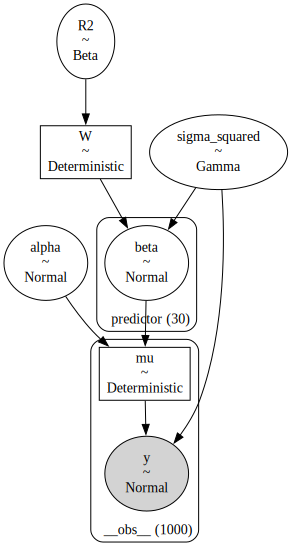

In [12]:
coords = {
    "predictor": np.arange(p),
    "__obs__": np.arange(n)
}

with pm.Model(coords=coords) as model_2:
    sigma_squared = pm.Gamma("sigma_squared", mu=9, sigma=2) # Informative prior
    
    # Non-uniform prior to check something below
    R2 = pm.Beta("R2", alpha=5, beta=3) 
    phi = 1 / p # NOTE: This is the change, now these are constant
    W = pm.Deterministic("W", R2 / (1 - R2))

    alpha = pm.Normal("alpha")
    beta = pm.Normal("beta", mu=0, sigma=(phi * W * sigma_squared) ** 0.5, dims="predictor")
    mu = pm.Deterministic("mu", alpha + (X_std @ beta), dims="__obs__")

    pm.Normal("y", mu=mu, sigma=sigma_squared ** 0.5, observed=y, dims="__obs__")

model_2.to_graphviz()

In [13]:
with model_2:
    idata_2 = pm.sample_prior_predictive(draws=10000, random_seed=1234)

Sampling: [R2, alpha, beta, sigma_squared, y]


We still see the same consistent behavior in the prior.

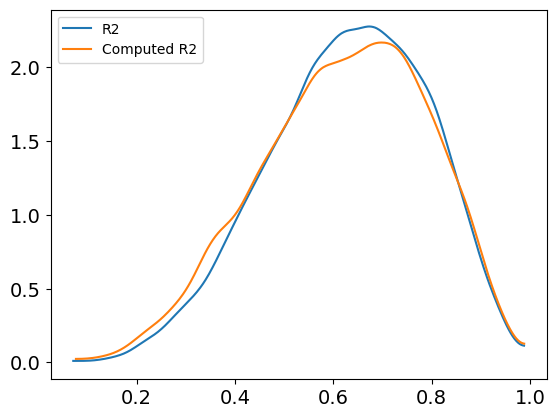

In [14]:
ax = az.plot_dist(idata_2.prior["R2"], label="R2")
az.plot_dist(compute_r2(idata_2.prior["mu"], idata_2.prior["sigma_squared"]), color="C1", label="Computed R2", ax=ax);

In [15]:
print(idata_2.prior["R2"].mean().item()) # Close to 5/8 = 0.625
print(compute_r2(idata_2.prior["mu"], idata_2.prior["sigma_squared"]).mean().item()) # Close to 5/8 = 0.625

0.6283262087752892
0.6197198990365727


In [16]:
with model_2:
    idata_2.extend(pm.sample(draws=2000, target_accept=0.99, random_seed=1234))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_squared, R2, alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


But now they're both centered at the same value... so what?

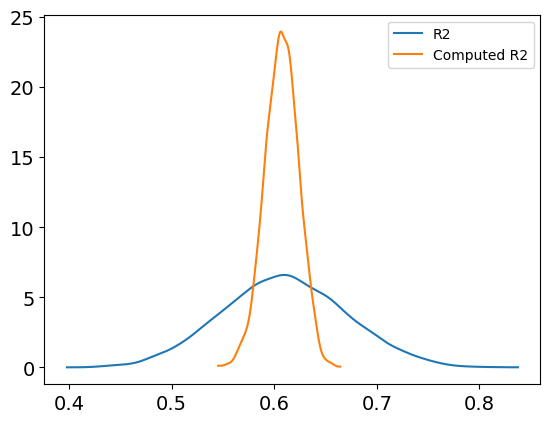

In [17]:
ax = az.plot_dist(idata_2.posterior["R2"], label="R2")
az.plot_dist(compute_r2(idata_2.posterior["mu"], idata_2.posterior["sigma_squared"]), color="C1", label="Computed R2", ax=ax);

## Notes

This is $R^2$ from Gelman's et al. paper 

$$
R^2 = \frac{\text{Explained variance}}{\text{Explained variance} + \text{Residual variance}} = \frac{\text{var}_\text{fit}}{\text{var}_\text{fit} + \text{var}_\text{res}}
$$

* $\text{var}_\text{fit} = V_{n=1}^N E(\tilde{y}_n \mid \theta)$
* $\text{var}_\text{res} = E(V_{n=1}^N(\tilde{y}_n - y_n^\text{pred} \mid \theta))$

I still don't know whta What can be explaining the difference. For some reason the parameter that is initially declared to be $R^2$ seems not to represent it anymore a posteriori.